**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Trabajo Práctico:** 1

**Datos de la entrega:** Jueves 26 de setiembre 2024, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo jupyter ( .IPYNB ) y todos los archivos adiconales que se requieran para correr su Cuaderno (En un archivo comprimido). En caso de requerir mucho espacio, solicitarle al profesor una carpeta en One-Drive para subir la solución.

---

**Estudiantes:**
- Andrey Arguedas Espinoza - 2020426569


# Trabajo Practico 1 - Andrey Arguedas Espinoza - 2020426569

## 0. Imports


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

from tensorflow.keras import models
from tensorflow.keras import layers

## 1 - Load Data

### • We load initially the data from the CSV file

In [2]:
#Load data from CSV path
csv_path = 'C:/Users/AndreyArguedas/Desktop/DeepLearning/Documentos de Deep Learning GR 40/TP1/ham10000_metadata_2024-09-01.csv'
df = pd.read_csv(csv_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11720 entries, 0 to 11719
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isic_id                 11720 non-null  object 
 1   attribution             11720 non-null  object 
 2   copyright_license       11720 non-null  object 
 3   age_approx              11337 non-null  float64
 4   anatom_site_general     9503 non-null   object 
 5   benign_malignant        9042 non-null   object 
 6   concomitant_biopsy      11720 non-null  bool   
 7   diagnosis               11720 non-null  object 
 8   diagnosis_confirm_type  11720 non-null  object 
 9   image_type              11719 non-null  object 
 10  lesion_id               11720 non-null  object 
 11  melanocytic             11720 non-null  bool   
 12  sex                     11377 non-null  object 
dtypes: bool(2), float64(1), object(10)
memory usage: 1.0+ MB


## • Now we build a dataset composed by the images and the corresponding label values (melanocytic = True/False)

### We also apply a resize of 50% on the images dimensions in order to reduce the memory consumption that we will have to do while building, splitting and handling the data

In [3]:
#Build dataset with images + corresponding label
images = []
labels = []
n = 0
data_path = 'C:/Users/AndreyArguedas/Desktop/DeepLearning/Documentos de Deep Learning GR 40/TP1/ISIC/'
#max_images = 200

for filename in os.listdir(data_path):
    # Open the image
    img_path = os.path.join(data_path, filename)
    # Resize the image to consume less resources and be able to load more data
    img = Image.open(img_path).resize((300,225), Image.LANCZOS)
    # Convert the image to a NumPy array for easier handling
    img_array = np.array(img)
    # Add the new image arrary to list of data
    images.append(img_array)
    #We pair the label data with the image we are loading
    labels.append(df.loc[df['isic_id'] == filename.replace(".jpg", ""), 'melanocytic'].values[0])

    #Add extras to see if it learns better
    if df.loc[df['isic_id'] == filename.replace(".jpg", ""), 'melanocytic'].values[0] == False:
        rotated_img = img.rotate(90)
        img_array = np.array(rotated_img)
        images.append(img_array)
        labels.append(False)
    
    n += 1
    if n % 1000 == 0:
        print("Number of images loaded:", n)  
    #if n == max_images:
        #break

# Convert the list of images into a single NumPy array
images_data_array = np.array(images)

# Check the shape of the resulting NumPy array
print(images_data_array.shape)

Number of images loaded: 1000
Number of images loaded: 2000
Number of images loaded: 3000
Number of images loaded: 4000
Number of images loaded: 5000
Number of images loaded: 6000
Number of images loaded: 7000
Number of images loaded: 8000
Number of images loaded: 9000
Number of images loaded: 10000
Number of images loaded: 11000
(14398, 225, 300, 3)


In [4]:
dataset_images_trainX = images_data_array
dataset_images_trainY = np.array(labels)

print("Size of images dataset: ", dataset_images_trainX.shape)
print("Size of labels: ", dataset_images_trainY.shape)

Size of images dataset:  (14398, 225, 300, 3)
Size of labels:  (14398,)


## 2 - Visualize the first 10 images to see they are loading correctly and with its corresponding Melanocytic value


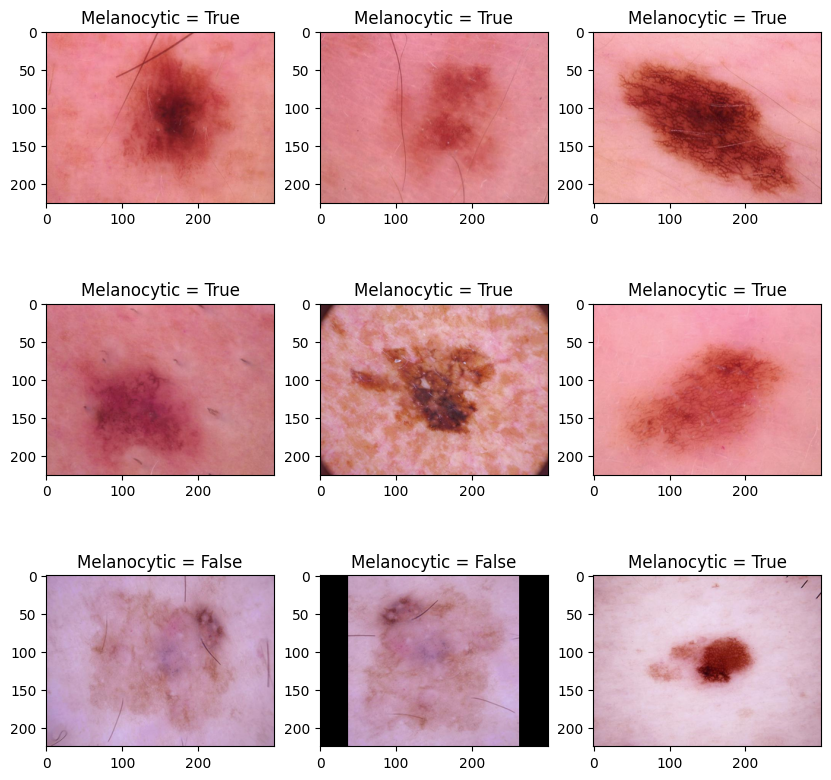

In [5]:
plt.figure(figsize=(10, 10))

for index, digit in zip(range(0, 9), dataset_images_trainX[:10]):
    plt.subplot(3, 3, index + 1)
    plt.imshow(digit)
    if dataset_images_trainY[index] == 1:
      plt.title("Melanocytic = True")
    else:
      plt.title("Melanocytic = False")
plt.show()

## 3 - We validate that we have the same proportion of True-False values from our loaded images


In [6]:
print("**********Melanocytic: values distribution from data loaded from CSV files**************\n")
print(df['melanocytic'].value_counts() , "\n")

print("**********Melanocytic: values distribution from builded dataset **************\n")
print("Count of positives for Melanocytic:" , len(list(filter(lambda i: i == 1, dataset_images_trainY))))
print("Count of false for Melanocytic:" , len(list(filter(lambda i: i == 0, dataset_images_trainY))))

**********Melanocytic: values distribution from data loaded from CSV files**************

melanocytic
True     9042
False    2678
Name: count, dtype: int64 

**********Melanocytic: values distribution from builded dataset **************

Count of positives for Melanocytic: 9042
Count of false for Melanocytic: 5356


## 4 - Data Preparation and splitting the dataset


## We split the data in a proportion of 60% training, 20% validation and 20% test

In [7]:
from sklearn.model_selection import train_test_split

# Step 1: Split into train (60%) and remaining (40%)
X_train, X_remaining, y_train, y_remaining = train_test_split(dataset_images_trainX, dataset_images_trainY, train_size=0.6, random_state=42)


# Step 2: Split remaining data into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

print("Dimensions of training data: ", X_train.shape)
print("Dimensions of training labels: ", y_train.shape)

print("Dimensions of validation data: ", X_val.shape)
print("Dimensions of validation labels: ", y_val.shape)

print("Dimensions of test data: ", X_test.shape)
print("Dimensions of test data: ", y_test.shape)


Dimensions of training data:  (8638, 225, 300, 3)
Dimensions of training labels:  (8638,)
Dimensions of validation data:  (2880, 225, 300, 3)
Dimensions of validation labels:  (2880,)
Dimensions of test data:  (2880, 225, 300, 3)
Dimensions of test data:  (2880,)


### Now we do data normalization and pixel value transformation across our splitting data 

In [8]:
d1, d2, d3, d4 = X_train.shape

X_train_prep = X_train.reshape((d1, d2*d3*d4))
X_train_prep = X_train_prep.astype('float32') / 255

d1, d2, d3, d4 = X_test.shape

X_test_prep = X_test.reshape((d1, d2*d3*d4))
X_test_prep = X_test_prep.astype('float32') / 255

d1, d2, d3, d4 = X_val.shape

X_val_prep = X_val.reshape((d1, d2*d3*d4))
X_val_prep = X_val_prep.astype('float32') / 255

print("Example of pixel transformation for an image", X_train_prep[0])


Example of pixel transformation for an image [0.8745098  0.54901963 0.5176471  ... 0.8        0.5568628  0.49803922]


## 5-  Define the Neural Network Architecture

In [9]:
network = models.Sequential()

network.add(layers.Dense(250, activation='relu', input_shape=(300*225*3,)))
network.add(layers.Dense(85, activation='relu'))
network.add(layers.Dense(20, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

In [10]:
network.summary()

network.layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               50625250  
                                                                 
 dense_1 (Dense)             (None, 85)                21335     
                                                                 
 dense_2 (Dense)             (None, 20)                1720      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 50,648,326
Trainable params: 50,648,326
Non-trainable params: 0
_________________________________________________________________


## 6 - Set the Neural Network configuration

In [11]:
network.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy', 'Precision'])

## 7 - Training phase

In [12]:
history = network.fit(X_train_prep,
                      y_train,
                      epochs=10,
                      validation_data=(X_val_prep, y_val))

Epoch 1/10
270/270 [==============================] - 37s 133ms/step - loss: 3.4462 - accuracy: 0.7607 - precision: 0.8102 - val_loss: 0.5359 - val_accuracy: 0.8090 - val_precision: 0.9183
Epoch 2/10
270/270 [==============================] - 36s 133ms/step - loss: 0.7346 - accuracy: 0.7978 - precision: 0.8337 - val_loss: 0.4151 - val_accuracy: 0.8316 - val_precision: 0.7933
Epoch 3/10
270/270 [==============================] - 39s 146ms/step - loss: 0.4753 - accuracy: 0.8164 - precision: 0.8365 - val_loss: 0.3113 - val_accuracy: 0.8538 - val_precision: 0.8291
Epoch 4/10
270/270 [==============================] - 39s 143ms/step - loss: 0.3787 - accuracy: 0.8228 - precision: 0.8340 - val_loss: 0.5627 - val_accuracy: 0.8160 - val_precision: 0.7746
Epoch 5/10
270/270 [==============================] - 37s 138ms/step - loss: 0.3690 - accuracy: 0.8303 - precision: 0.8367 - val_loss: 0.3934 - val_accuracy: 0.8229 - val_precision: 0.7820
Epoch 6/10
270/270 [==============================] - 3

## 8 - Visualize metrics from the training phase

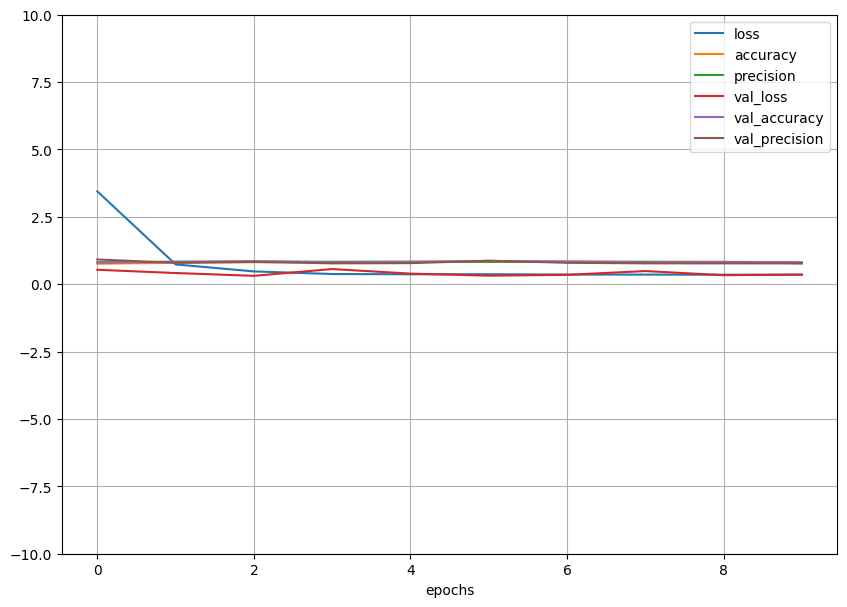

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(-10, 10)
plt.xlabel("epochs")
plt.show()

In [14]:
test_loss, test_acc, test_prec = network.evaluate(X_test_prep, y_test)
print('Test accuracy: ', test_acc)
print('Test Precision:', test_prec)
print('Test Loss:', test_prec)

90/90 [==============================] - 3s 35ms/step - loss: 0.3805 - accuracy: 0.8094 - precision: 0.7653
Test accuracy:  0.809374988079071
Test Precision: 0.765262246131897
Test Loss: 0.765262246131897


## 9 - Prediction of new examples

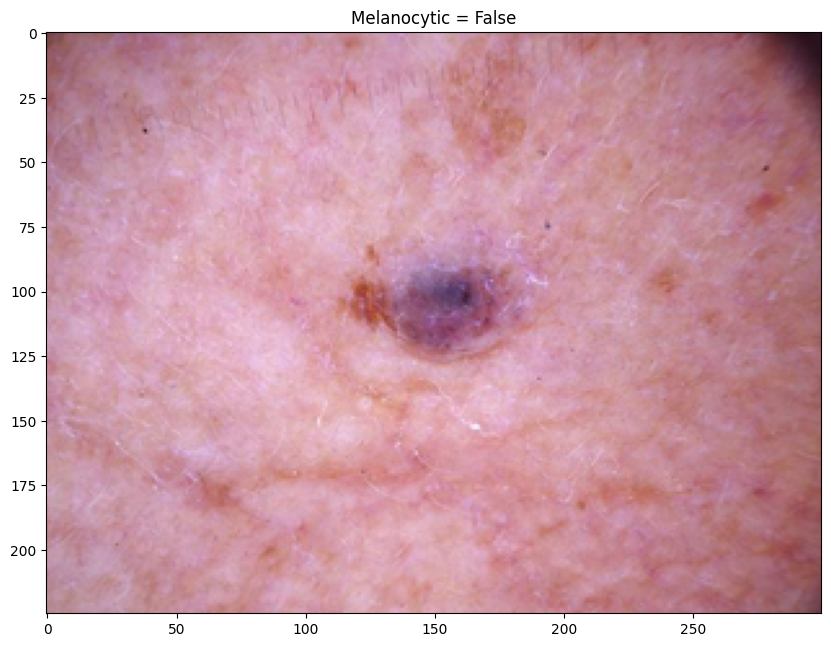

In [15]:
# Let's suppose X_new is a new image that has never been seen by our model
new_index = 0
X_new = X_test[new_index]

plt.figure(figsize=(10, 10))

plt.imshow(X_new)
if y_test[new_index] == 1:
  plt.title("Melanocytic = True")
else:
  plt.title("Melanocytic = False")

plt.show()



## • Every new image we need to normalize the data and transform the pixels

In [16]:
# Every new image we need to normalize the data and transform the pixels
d1, d2, d3 = X_new.shape

X_new_prep = X_new.reshape((1, d1*d2*d3))
X_new_prep = X_new_prep.astype('float32') / 255

### • Now we can predict the new image

In [17]:
# Do the prediction
y_pred = network.predict(X_new_prep)
print("Predicted: ", y_pred)
print("Actual value: ", y_test[new_index])


# Realizamos la prediccion obteniendo una clase en lugar de una probabilidad
print("Class predicted", np.round(y_pred)[0])

1/1 [==============================] - 0s 152ms/step
Predicted:  [[0.7539722]]
Actual value:  False
Class predicted [1.]


### • Now we check against the test set how many images predicted for each melanocytic value

In [18]:
predictions = network.predict(X_test_prep)
unique_predictions, counts = np.unique(np.round(predictions), return_counts=True)
print(f"Counts of predictions melanocytics = True: {counts[1]}")
print(f"Counts of predictions melanocytics = False: {counts[0]}")
unique_originals, counts_originals = np.unique(y_test, return_counts=True)
print(f"Counts of originals test melanocytics = True: {counts_originals[1]}")
print(f"Counts of originals test melanocytics = False: {counts_originals[0]}")


90/90 [==============================] - 3s 35ms/step
Counts of predictions melanocytics = True: 2326
Counts of predictions melanocytics = False: 554
Counts of originals test melanocytics = True: 1783
Counts of originals test melanocytics = False: 1097
